In [1]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy
from sklearn.model_selection import StratifiedKFold
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import get_ensg_id, estimate_s, CCC

In [2]:
plt.rcParams['font.size'] = '18'
plt.rcParams['lines.linewidth'] = 6
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# Load data

In [7]:
rna = sc.read('/home/mffang/data/counts/Klein/pure/counts_filtered/adata.loom',validate=False)
rna

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 1530 × 62754
    obs: 'barcode'
    var: 'target_name'
    layers: 'ambiguous', 'mature', 'nascent'

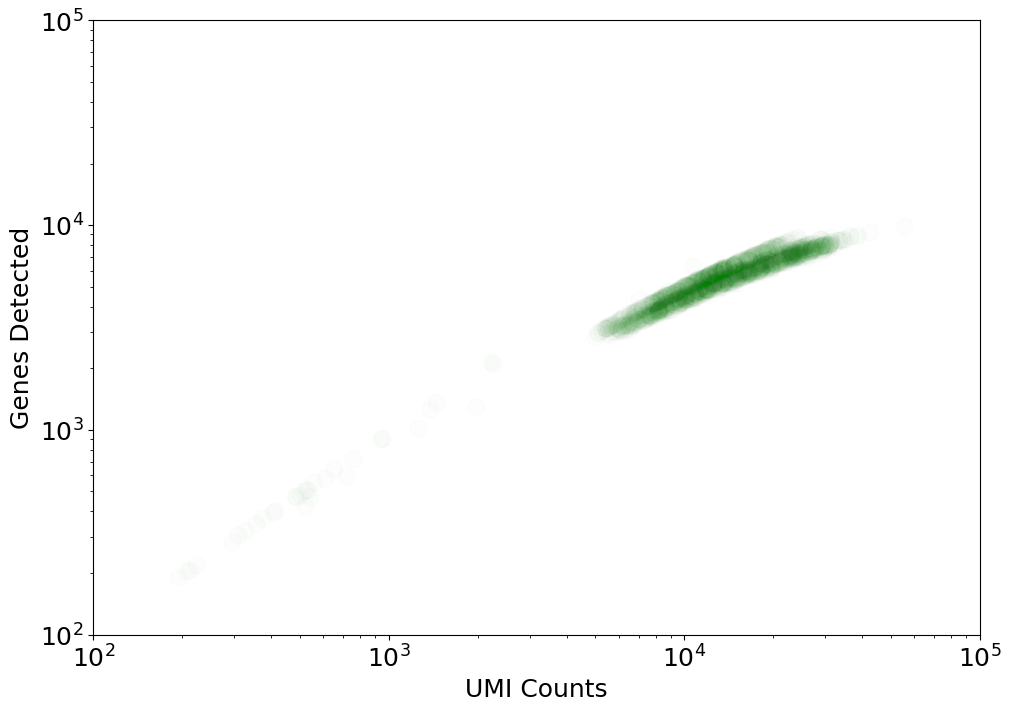

In [9]:
mtx = rna.layers['ambiguous'].toarray()+rna.layers['mature'].toarray()+rna.layers['nascent'].toarray() 

fig, ax = plt.subplots(figsize=(10, 7))

ax.scatter(np.asarray(mtx.sum(axis=1)), np.asarray(np.sum(mtx>0, axis=1)), color="green", alpha=0.01)
ax.set_xlabel("UMI Counts")
ax.set_ylabel("Genes Detected")
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlim((100,100000))
ax.set_ylim((100,100000))

plt.show()

In [10]:
rna.obs

,barcode
0,AAAAAAAAAAAAAAAAAAA
1,AAAACCTCCGATACGAAAC
2,AAAACGCCTGATACCCAAT
3,AAAACGCCTGATTCCCAAT
4,AAAAGCCTAGATAGGTTGT
...,...
1525,TTGGACTTGAGTCCCAATC
1526,TTTGTGTCGAGAGGCCTGT
1527,TTTGTGTCGAGGCAGCGAG
1528,TTTGTGTCGAGTGGCCTGT


In [11]:
rna.var

,target_name
0,ENSG00000279928.2
1,ENSG00000228037.1
2,ENSG00000142611.17
3,ENSG00000284616.1
4,ENSG00000157911.11
...,...
62749,ENSG00000271254.7
62750,ENSG00000275987.1
62751,ENSG00000268674.2
62752,ENSG00000277475.1


In [44]:
adata = rna.copy()
adata.layers['unspliced'] = adata.layers['nascent'] 
adata.layers['spliced'] = adata.layers['mature'] #+ adata.layers['ambiguous']

# Calculate CV$^2$ of read depth

0.04698949 0.027418371


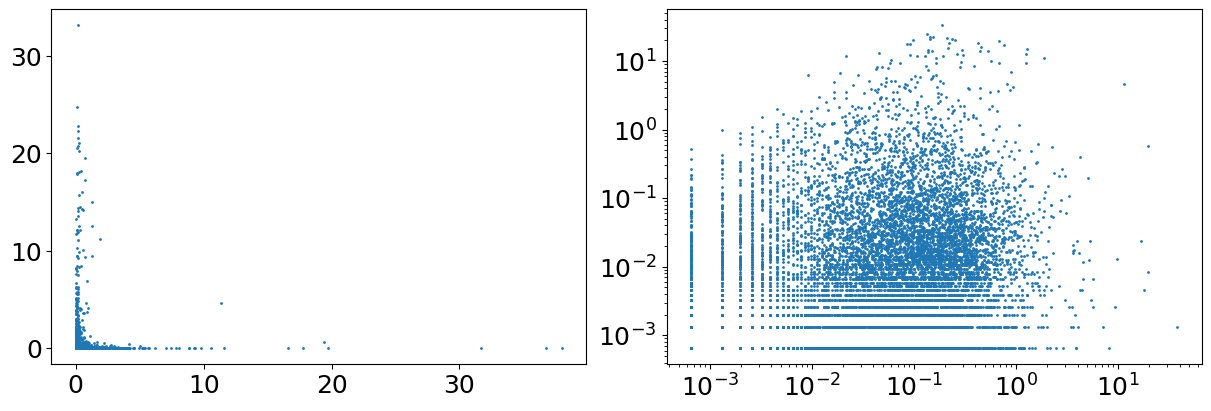

In [45]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

s estimated by total counts = 0.21866944933707114
3659 su= 0.23407967073964037
3978 ss= 0.2167320824601012
3732 s= 0.2214626568437144


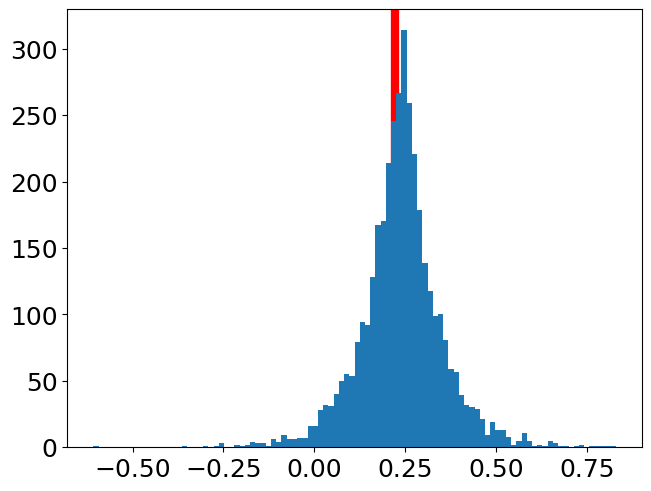

In [95]:
su, ss, sp = estimate_s(adata)

In [104]:
idx = (adata.layers["spliced"].toarray().mean(0) > 0.01) & (adata.layers["unspliced"].toarray().mean(0) > 0.01)
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
U.sum(),S.sum()

(1396270.0, 2419172.0)

In [105]:
X = np.concatenate((U,S),axis=1)
p = U.shape[1]
p

4010

In [106]:
eta = np.cov(U,S,rowvar=False)/X.mean(0)[:,None]/X.mean(0)[None,:]
P = eta.shape[0]

In [107]:
s = (np.sum(eta)-np.sum(np.diag(eta)))/((P-1)*P)
eta.mean(),s

(0.2259290193054691, 0.22280695180218152)

0.23603955489872078

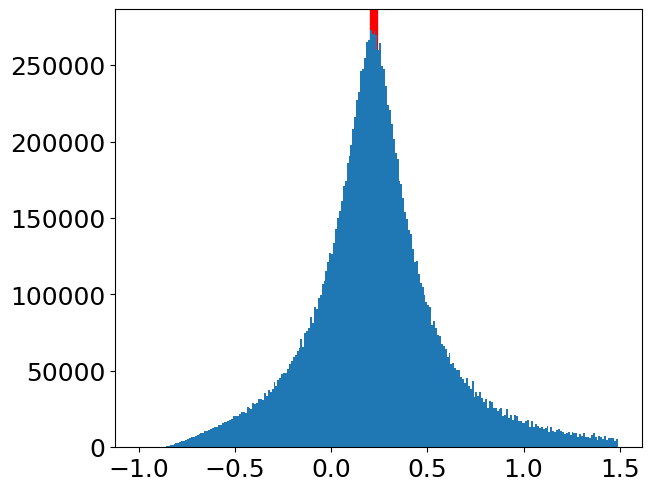

In [113]:
eta_ = eta[:p,:p]
plt.hist(eta_.flatten(),bins=np.arange(-1,1.5,0.01));
plt.axvline(x=sp,c='r',zorder=0)
(np.sum(eta_)-np.sum(np.diag(eta_)))/((p-1)*p)

0.2168250665091474

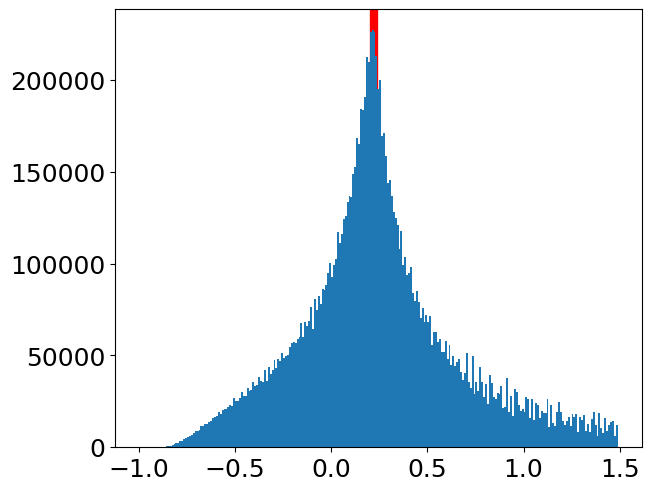

In [112]:
eta_ = eta[p:,p:]
plt.hist(eta_.flatten(),bins=np.arange(-1,1.5,0.01));
plt.axvline(x=sp,c='r',zorder=0)
(np.sum(eta_)-np.sum(np.diag(eta_)))/((p-1)*p)

0.21919474800514696

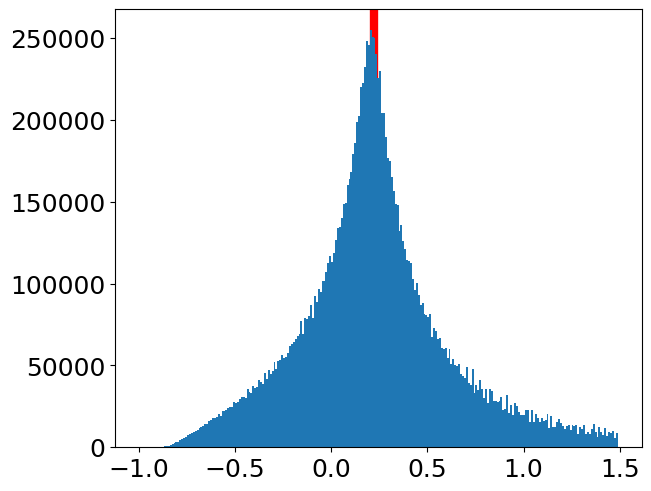

In [111]:
eta_ = eta[p:,:p]
plt.hist(eta_.flatten(),bins=np.arange(-1,1.5,0.01));
plt.axvline(x=sp,c='r',zorder=0)
(np.sum(eta_)-np.sum(np.diag(eta_)))/((p-1)*p)

Text(0.02, 0.5, 'CV$^2$')

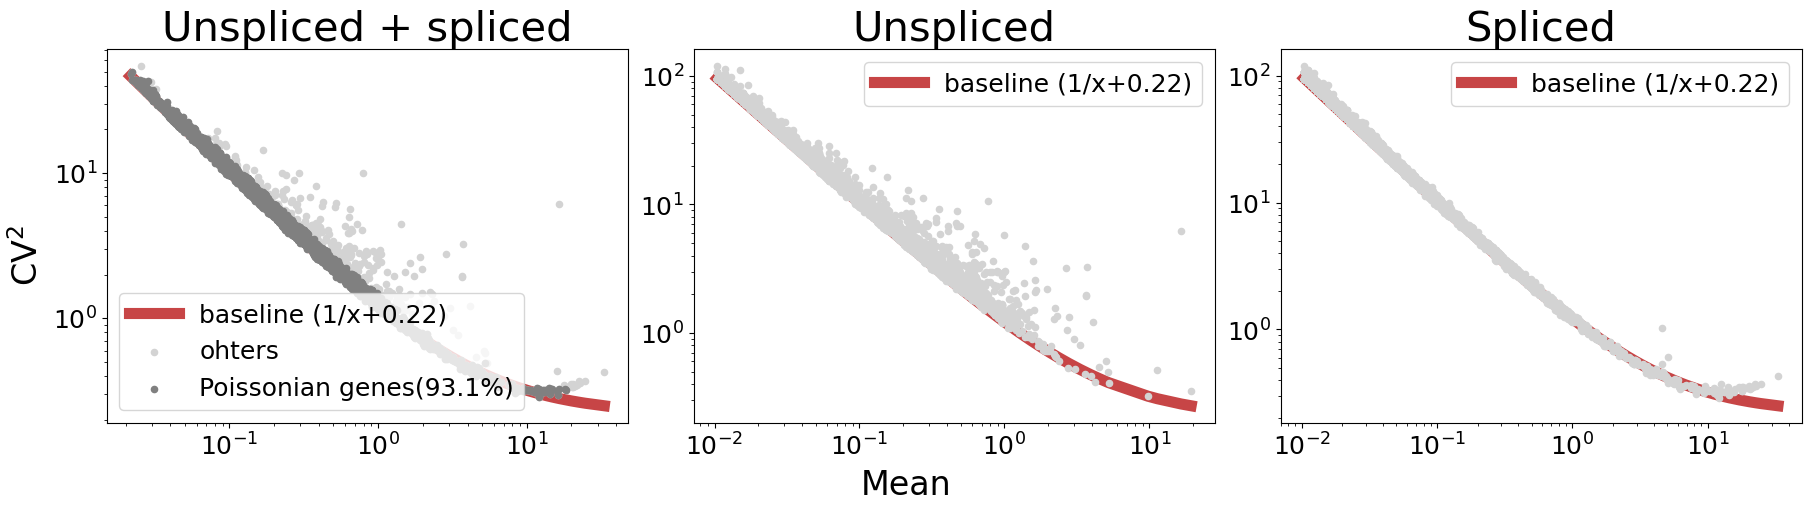

In [151]:
a=1
sp = su = ss = s = 0.22
X = U + S
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(a*X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), a/np.sort(X_mean) + sp, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), a/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
#ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), a/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
#ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes ('+str(np.around(100*np.sum(Pgene_mask)/len(X_bar),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

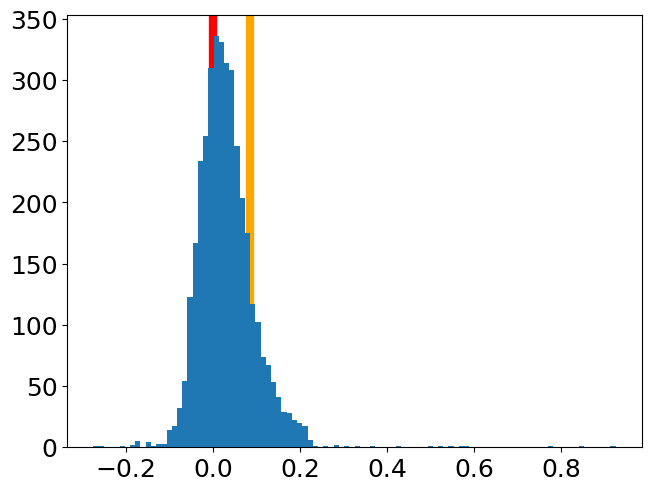

In [153]:
plt.hist((X_var[Pgene_mask]-X_mean[Pgene_mask])/X_mean[Pgene_mask]-sp*X_mean[Pgene_mask],bins=100);
plt.axvline(x=0,c='r',zorder=0)
plt.axvline(x=0.07*(1+ss),c='orange',zorder=0)

# Check covariance relationships

In [154]:
min_mean = 0.01
s = ss
idx = (adata.layers["spliced"].toarray().mean(0) > min_mean) & (adata.layers["unspliced"].toarray().mean(0) > min_mean)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

zeta_uu = ((U_var-U_mean)/U_mean**2-s)/(1+s)
zeta_ss = ((S_var-S_mean)/S_mean**2-s)/(1+s)

cov_us = []
for i in np.arange(len(U_mean)):
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_us = np.array(cov_us)
zeta_us = ((cov_us)/S_mean/U_mean-s)/(1+s)
zeta_us.shape

(4010,)

## $Var(N_U)$

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


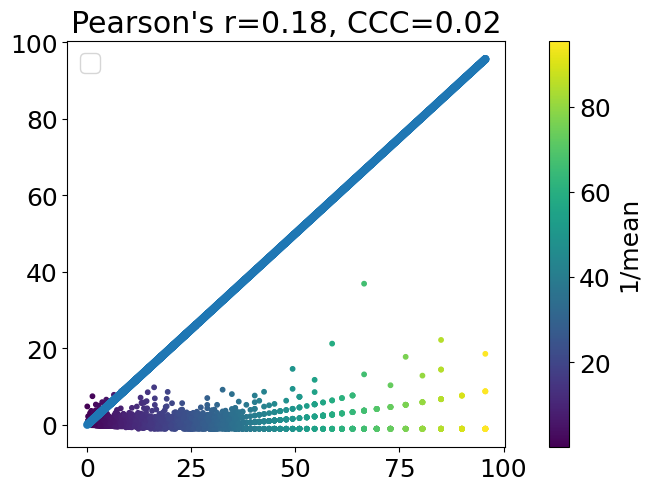

In [155]:
x = 1/U_mean
y = zeta_uu
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.plot(x,x)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

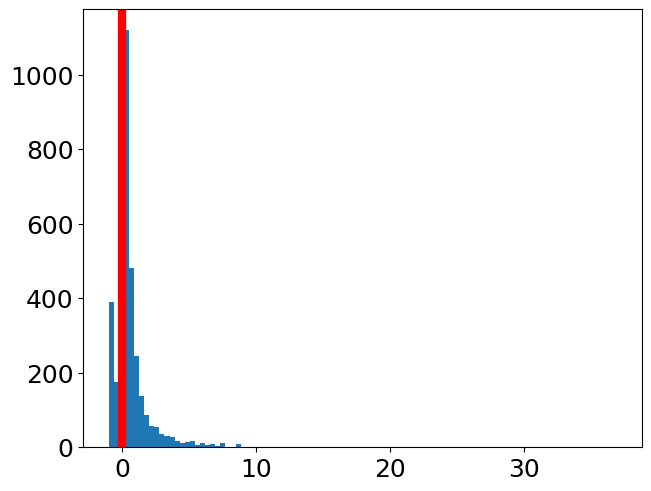

In [156]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')

## $Cov(N_u,N_s)$ 

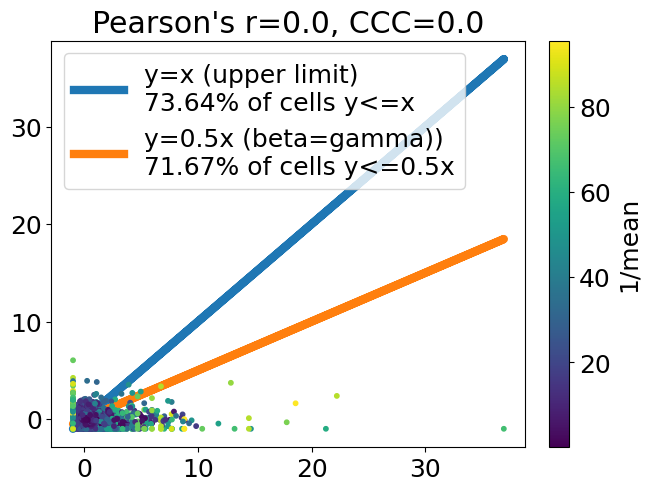

In [157]:
x=zeta_uu
y=zeta_us

plt.plot(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend()

## $Var(N_s)$ 

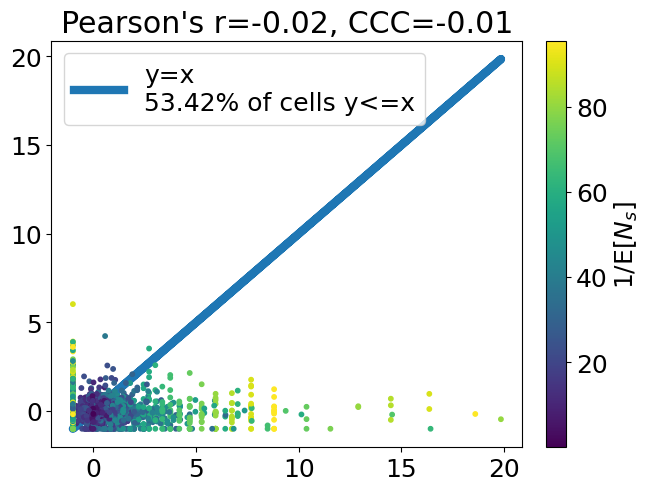

In [158]:
x=zeta_ss
y=zeta_us

plt.plot(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()